# Прогнозирование температуры плавления стали

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.



**Цель проекта**

Разработать модель для предсказания температуры стали, чтобы оптимизировать производственные расходы.

**План работы**

1. *Загрузка данных.* Загрузить полученные данные и выполнить их первичный осмотр.
2. *Исследовательский анализ и предобработка данных.* Выполните исследовательский анализ каждого датафрейма и при необходимости выполните предобработку. Сделайте выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
3. *Объединение данных и исследовательский анализ.* Объединить выбранные признаки в один датафрейм по ключу. Выполнить исследовательский анализ объединённого датафрейма, визуализировать распределения признаков и при необходимости выполните предобработку. Проведите корреляционный анализ.
5. *Подготовка данных.* Выполните подготовку данных для обучения модели. Разделите данные на две выборки.
6. *Обучение моделей машинного обучения.* Обучить как минимум две модели и подобрать из них как минимум два гиперпараметра.
7. *Выбор лучшей модели.* Выберать лучшую модель и проверьте её качество на тестовой выборке.
8. *Сделать общий вывод и дать рекомендации заказчику.* 

**Данные**

Данные состоят из нескольких датафреймов:

* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

In [1]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем нужные бибилиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

In [3]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression , Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Константы

RANDOM_STATE = 250722

In [6]:
# Функция загрузки датафрейма

def load_data(name):
    try:
        data = pd.read_csv(f'{name}.csv')
    except:
        data = pd.read_csv(f'/datasets/{name}.csv')
    return data

In [7]:
# Функция общей информации о датафрейме

def info(df):
    display(df.head(5))
    print()
    print('-' * 150)
    print()
    print('Общая информация:')
    display(df.info())
    print()
    print('-' * 150)
    print()
    display(df.describe())
    print()
    print('-' * 150)
    print()
    print('Количество пропусков для каждого столбца:')
    display(df.isnull().sum())

In [8]:
# Функция для визуализации важности признаков, после обучения моделей

def features_importances_plot(features_importances, features_names, model_name):
    feat_importances = pd.Series(features_importances, index=features_names).sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    sns.barplot(x=feat_importances.index, y=feat_importances.values)
    plt.grid()
    plt.title(f'Наиболее значимые признаки для модели {model_name}')
    plt.xticks(rotation=90);

## Загрузка данных

**Данные об электродах**

Файл - *data_arc_new.csv*

* key — номер партии;
* Начало нагрева дугой — время начала нагрева;
* Конец нагрева дугой — время окончания нагрева;
* Активная мощность — значение активной мощности;
* Реактивная мощность — значение реактивной мощности.

In [9]:
data_arc = load_data('data_arc_new')
info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

**Данные о подаче сыпучих материалов (объём)**

Файл - *data_bulk_new.csv*

* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

In [10]:
data_bulk = load_data('data_bulk_new')
info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory u

None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Данные о подаче сыпучих материалов (время)**

Файл - *data_bulk_time_new.csv*

* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

In [11]:
data_bulk_time = load_data('data_bulk_time_new')
info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Данные о продувке сплава газом**

Файл - *data_gas_new.csv*

* key — номер партии;
* Газ 1 — объём подаваемого газа.

In [12]:
data_gas = load_data('data_gas_new')
info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key      0
Газ 1    0
dtype: int64

**Данные о результатах измерения температуры**

Файл - *data_temp_new.csv*

* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

In [13]:
data_temp = load_data('data_temp_new')
info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key                0
Время замера       0
Температура     3427
dtype: int64

**Данные о проволочных материалах (объём)**

Файл - *data_wire_new.csv*

* key — номер партии;
* Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

In [14]:
data_wire = load_data('data_wire_new')
info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Данные о проволочных материалах (время)**

Файл - *data_wire_time_new.csv*

* key — номер партии;
* Wire 1 … Wire 9 — время подачи проволочных материалов.

In [15]:
data_wire_time = load_data('data_wire_time_new')
info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

На этапе загрузки данных и проведения первичного осмотра можно сделать следующие **выводы**:

1. Изменение типа данных в столбцах "Начало нагрева дугой" и "Конец нагрева дугой" в датасете data_arc:

* Преобразование этих столбцов в тип данных datetime позволит упростить дальнейший анализ, так как это обеспечит возможность выполнения временных операций, таких как вычисление разницы между датами, фильтрация по времени и группировка данных. 

* Кроме того, стоит рассмотреть возможность добавления нового столбца, который будет представлять собой длительность нагрева (в секундах). Это может быть полезно для анализа эффективности процесса нагрева и выявления аномалий.

2. Анализ пропусков в датасетах:

* В датасетах data_bulk, data_bulk_time, data_wire, data_wire_time необходимо провести детальный анализ пропусков. Важно выяснить, какие именно данные отсутствуют и в каких столбцах.
  
* Также определить процентное соотношение пропущенных данных.

3. Изменение типа данных в других датасетах:

* В датасетах data_wire_time, data_temp, data_bulk_time также следует изменить тип данных на datetime. Это упростит анализ временных рядов и позволит более эффективно работать с временными метками.

* Преобразование типов данных в этих датасетах также может помочь в выявлении закономерностей и трендов, связанных с изменениями температуры и другими временными параметрами.

4. Преобразование отрицательных значений в столбце "Реактивная мощность" в датасете data_arc:

* Отрицательные значения в столбце "Реактивная мощность" могут указывать на ошибки в данных или на физически невозможные состояния. Решением будет преобразование этих значений в положительные, взяв их модуль, либо посмотреть корреляцию между реактивной и активной мощностями, а затем найти значение реактивной мощности в зависимоти от активной. Это позволит избежать искажений в анализе и обеспечит корректность расчетов, связанных с реактивной мощностью.

5. Обработка названий столбцов в соответствии с PEP8:

* Приведем названия столбцов к "змеиному" виду, но оставим названия на русском для удобства.

## Исследовательский анализ и предобработка данных

**Датасет data_arc:**

*Данные об электродах*

* Заменим пробелы в названиях столбцов на нижний прочерк и приведем все к нижнему регистру.
* Приведем время к формату datetime, найдем общее время нагрева в секундах, равное разницы начала и конца нагрева дугой, а также удалим столбцы с началом и концом нагрева дугой. Проанализируем полученное время нагрева и время нагрева для каждой партии.
* Найдем общее количество партий и среднее количество итераций.
* Обработаем отрицательные значения в столбце *Реактивная мощность* - данное значение слишком велико по модулю, поэтому используем корреляцию в зависимости от активной мощности для заполнения аномалии.
* Добавим столбец с общей мощностью, равной сумму активнолй и реактивной мощностей.
* Сгруппируем данные по ключу, то есть объединит иттерации по партии, и применим к каждому столбцу агрегирующие функции: для столбца "время_нагрева_дугой" - сумма, для "мощность" - сумма.

In [16]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [17]:
data_arc = data_arc.rename(columns={
                                    'Начало нагрева дугой': 'начало_нагрева_дугой',
                                    'Конец нагрева дугой': 'конец_нагрева_дугой',
                                    'Активная мощность': 'активная_мощность',
                                    'Реактивная мощность': 'реактивная_мощность'
})

data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [18]:
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'])
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'])

In [19]:
data_arc['время_нагрева_дугой'] = (data_arc['конец_нагрева_дугой'] -  data_arc['начало_нагрева_дугой']).dt.total_seconds()

In [20]:
data_arc = data_arc.drop(['начало_нагрева_дугой', 'конец_нагрева_дугой'], axis = 1)

In [21]:
display(data_arc.head(5))

display(data_arc.describe(include='all'))

,key,активная_мощность,реактивная_мощность,время_нагрева_дугой
0,1,0.305130,0.211253,228.0
1,1,0.765658,0.477438,185.0
2,1,0.580313,0.430460,172.0
3,1,0.518496,0.379979,365.0
4,1,0.867133,0.643691,148.0


,key,активная_мощность,реактивная_мощность,время_нагрева_дугой
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986,171.670946
std,934.571502,0.258885,5.873485,98.186803
min,1.000000,0.223120,-715.479924,11.000000
25%,806.000000,0.467115,0.337175,107.000000
50%,1617.000000,0.599587,0.441639,147.000000
75%,2429.000000,0.830070,0.608201,214.000000
max,3241.000000,1.463773,1.270284,907.000000


In [22]:
print(f"Общее количество партий равно {data_arc['key'].nunique()}.")

Общее количество партий равно 3214.


In [23]:
print(f"Среднее количество итераций для одной партии равно {round(data_arc['key'].count() / data_arc['key'].nunique(), 2)}.")

Среднее количество итераций для одной партии равно 4.63.


In [24]:
# Рассмотрим отрицательное значение реактивной мощности

data_arc.query('реактивная_мощность <= 0')

,key,активная_мощность,реактивная_мощность,время_нагрева_дугой
9780,2116,0.705344,-715.479924,109.0


In [25]:
print('Корреляция между активной и реактивной мощностью')

data_arc.query('index != 9780')[['активная_мощность', 'реактивная_мощность']].corr()

Корреляция между активной и реактивной мощностью


,активная_мощность,реактивная_мощность
активная_мощность,1.000000,0.966373
реактивная_мощность,0.966373,1.000000


In [26]:
ratio_power = (data_arc.query('index != 9780')['реактивная_мощность'] / data_arc.query('index != 9780')['активная_мощность']).mean().round(2)

print(f'Реактивная мощность относится к активной в соотношении {ratio_power}')

Реактивная мощность относится к активной в соотношении 0.73


In [27]:
data_arc.loc[data_arc['реактивная_мощность'] < 0, 'реактивная_мощность'] = data_arc['активная_мощность'] * ratio_power
data_arc.query('реактивная_мощность <= 0')

,key,активная_мощность,реактивная_мощность,время_нагрева_дугой


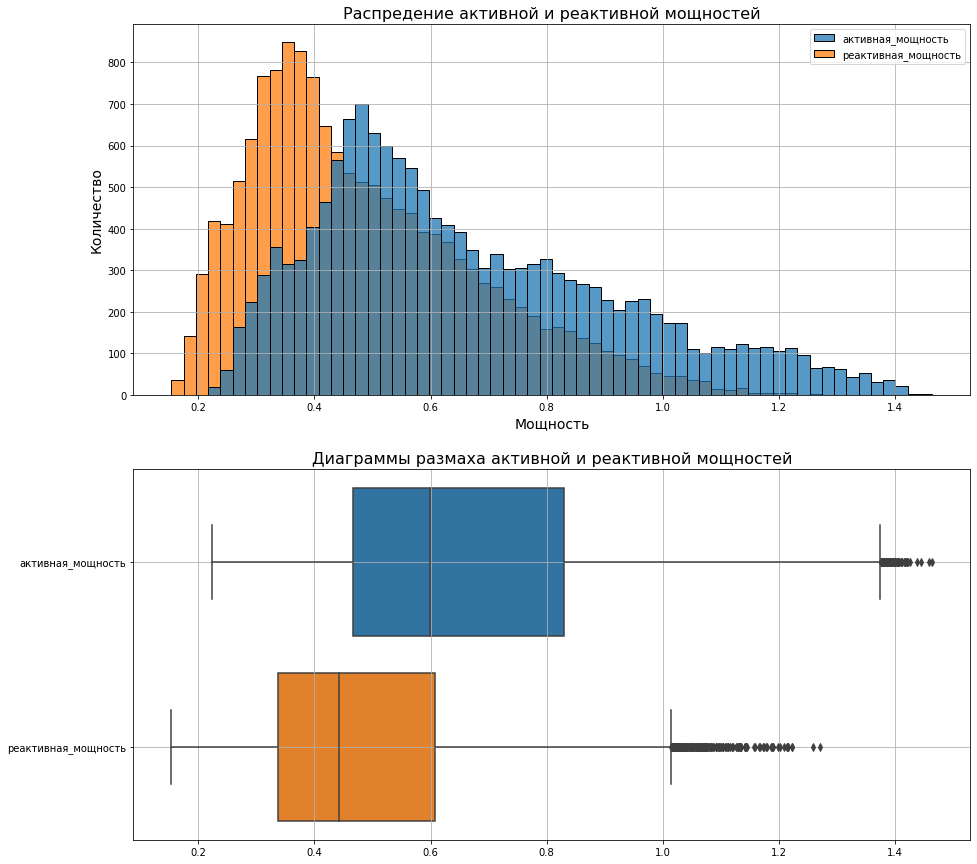

In [28]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_arc[['активная_мощность', 'реактивная_мощность']])
plt.title('Распредение активной и реактивной мощностей', fontsize=16)
plt.xlabel('Мощность', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(data=data_arc[['активная_мощность', 'реактивная_мощность']], orient='h')
plt.title('Диаграммы размаха активной и реактивной мощностей', fontsize=16)
plt.grid()

plt.show()

In [29]:
data_arc['мощность'] = ((data_arc['активная_мощность'])**2 + (data_arc['реактивная_мощность'])**2)**(0.5)

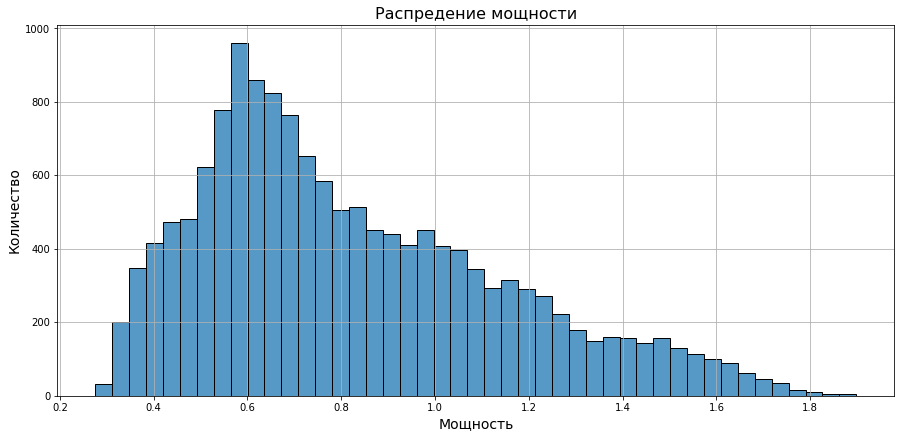

In [30]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_arc['мощность'])
plt.title('Распредение мощности', fontsize=16)
plt.xlabel('Мощность', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.show()

In [31]:
data_arc = data_arc.drop(['активная_мощность', 'реактивная_мощность'], axis = 1)

In [32]:
display(data_arc.время_нагрева_дугой.describe())

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: время_нагрева_дугой, dtype: float64

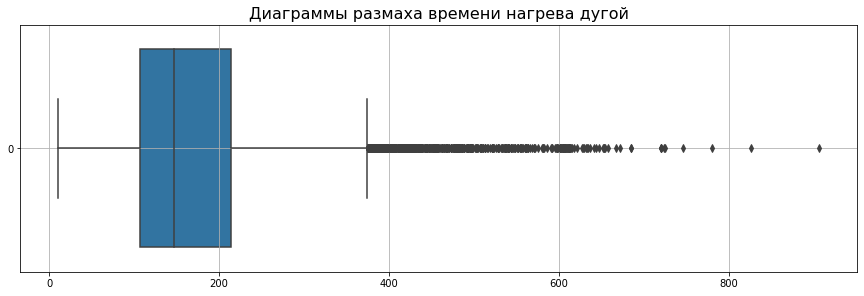

In [33]:
plt.figure(figsize=(15, 10))

plt.subplot(2,1,2)
sns.boxplot(data=data_arc['время_нагрева_дугой'], orient='h')
plt.title('Диаграммы размаха времени нагрева дугой', fontsize=16)
plt.grid()

plt.show()

In [34]:
agg_func_arc = {
    'key': 'count', 
    'время_нагрева_дугой': 'sum',
    'мощность': 'sum',
}

In [35]:
data_arc = data_arc.groupby('key').agg(agg_func_arc).rename(columns={'key':'количество_итераций'})
data_arc.head()

,количество_итераций,время_нагрева_дугой,мощность
key,,,
1,5,1098.0,3.718736
2,4,811.0,2.588349
3,5,655.0,5.019223
4,4,741.0,3.400038
5,4,869.0,2.816980


**Вывод:**

1. Общее количество партий 3214 со среднем количеством итераций 4.63 в одной партии.
2. Между активной и реактивной мощностью высокая положительная корреляция.
3. По графикам расрпределения активной и реактивной мощностей выбросов не наблюдается, значения выглядят реальными.
4. Максимальное время нагрева дугой равно 907 секунд, минимальное 11. Среднее время нагрева составляет 172 секунды. Все значения положительны.
5. Мы получили новый датафрейм *data* со сгрупперованными знаениями по партиям, примени агрегирующую функцию суммы к столбцам времени и мощности.

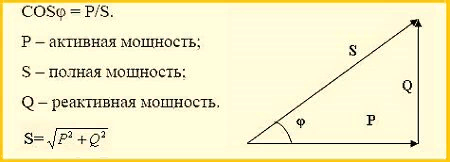

**Датасет data_bulk:**

*Данные о подаче сыпучих материалов*

* Заменим пробелы в названиях столбцов на нижний прочерк и приведем все к нижнему регистру.
* Рассмотрим количество добавлений материалов.
* Проверим данные на выбросы и аномалии.
* Все NaN в датафрейме заменим на нули для удобного нахождения суммы по партиям.

In [36]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [37]:
rename_dict = {f'Bulk {i}': f'bulk_{i}' for i in range(1, 16)}

data_bulk = data_bulk.rename(columns=rename_dict)

data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [38]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [39]:
data_bulk.query('bulk_12 == 1849')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


In [40]:
data_bulk = data_bulk.drop(index=303)

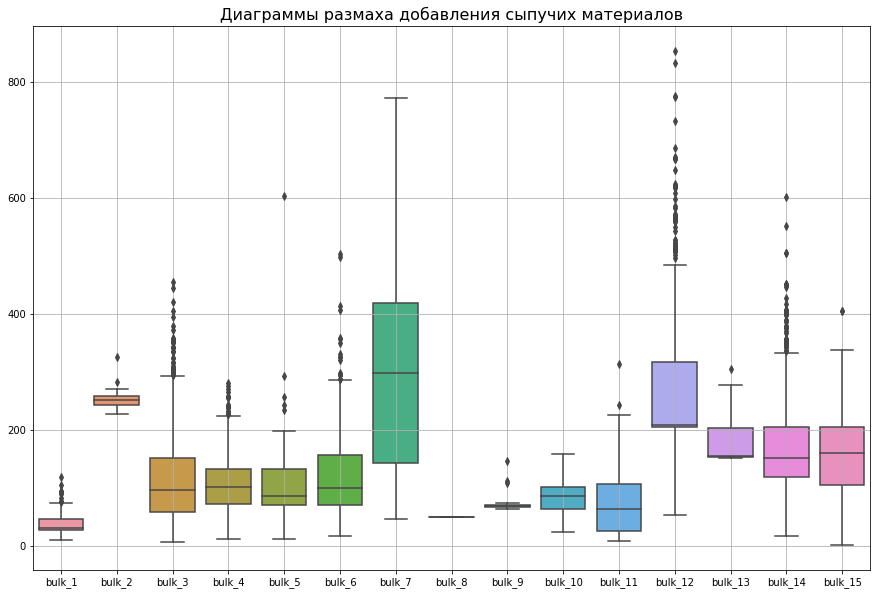

In [41]:
plt.figure(figsize=(15, 10))

sns.boxplot(data=data_bulk.drop(columns=['key']))
plt.title('Диаграммы размаха добавления сыпучих материалов', fontsize=16)
plt.grid()

plt.show()

In [42]:
data_bulk = data_bulk.fillna(0)

In [43]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [44]:
data_bulk['сыпучий_материал_сумма'] = data_bulk.sum(axis=1)

In [45]:
data_bulk.drop('bulk_8', axis=1, inplace=True)

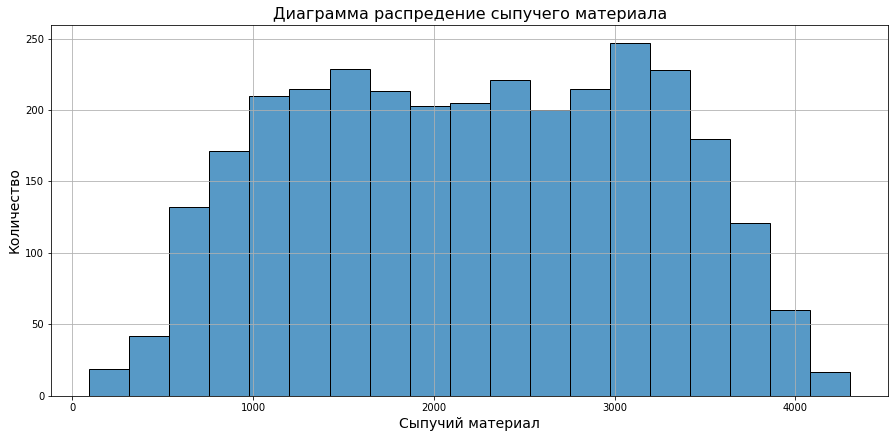

In [46]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_bulk['сыпучий_материал_сумма'])
plt.title('Диаграмма распредение сыпучего материала', fontsize=16)
plt.xlabel('Сыпучий материал', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.show()

In [47]:
data_bulk.set_index('key', inplace=True)

In [48]:
data_bulk.head(15)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,сыпучий_материал_сумма
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,554.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,584.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,547.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,599.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,589.0
6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,682.0
7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,634.0
8,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,922.0
9,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,535.0


**Вывод:**

* Материал 8 был добавлен всего лишь в одну партию - удалим его.
* У материала 12 встречается значение 1849 - оно похоже на анамалию. Удалим его.
* Медианное значение сыпучих материалов (не считая аномалии) колеблется от 39 до 305.
* Заменили все NaN на нули, чтобы просуммировать значения по партиям.

**Датасет data_bulk_time:**

*Данные о подаче сыпучих материалов (время)*

* Также обработаем названия в столбцах: заменим пробелы на нижнее подчеркивание.
* Учитывая, что мы удалили единственное значение 8 материала, стоит удалить данный столбец в нынешнем датафрейме.
* Преобразуем данные в формат даты.
* Аналогично первому датасету, создадим время (длительность) добавления сыпучих материалов, как разница начала и конца добавления материала. Для этого Будем ориентироваться на минимальное и максимальное значение времени.

In [49]:
rename_dict = {f'Bulk {i}': f'bulk_{i}' for i in range(1, 16)}

data_bulk_time = data_bulk_time.rename(columns=rename_dict)

data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [50]:
data_bulk_time.drop('bulk_8', axis=1, inplace=True)

In [51]:
for col in data_bulk_time.columns:
    if col.startswith('bulk_'):
        data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], errors='coerce')

In [52]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_9   19 non-null     datetime64[ns]
 9   bulk_10  176 non-null    datetime64[ns]
 10  bulk_11  177 non-null    datetime64[ns]
 11  bulk_12  2450 non-null   datetime64[ns]
 12  bulk_13  18 non-null     datetime64[ns]
 13  bulk_14  2806 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](14), int64(1)
memory usage: 366.8 KB


In [53]:
datetime_columns = data_bulk_time.select_dtypes(include=['datetime64[ns]'])

data_bulk_time['начало_насыпания_материала'] = datetime_columns.min(axis=1)
data_bulk_time['конец_насыпания_материала'] = datetime_columns.max(axis=1)

data_bulk_time['время_добавления_материала'] = (
    data_bulk_time['конец_насыпания_материала'] - 
    data_bulk_time['начало_насыпания_материала']
).dt.total_seconds()

In [54]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,начало_насыпания_материала,конец_насыпания_материала,время_добавления_материала
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:10:43,2019-05-03 11:28:48,1085.0
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,2019-05-03 11:53:30,1000.0
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:16:16,2019-05-03 12:32:39,983.0
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,2019-05-03 12:58:00,878.0
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,205.0


In [55]:
data_bulk_time = data_bulk_time[['key', 'время_добавления_материала']]
data_bulk_time.head()

,key,время_добавления_материала
0,1,1085.0
1,2,1000.0
2,3,983.0
3,4,878.0
4,5,205.0


In [56]:
data_bulk_time.set_index('key', inplace=True)

KeyError: 0

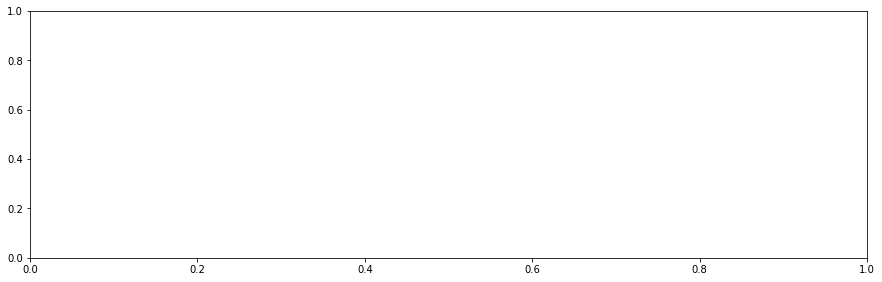

In [57]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 2)
sns.boxplot(data=data_bulk_time['время_добавления_материала'], orient='h')
plt.title('Диаграммы размаха времени добавления сыпучих материалов', fontsize=16)
plt.grid()

plt.show()

**Вывод:**

* Исправили названия столбцов в соответствии с PEP8.
* Убрали информацию о 8 материале.
* Преобразовали данные в формат datetime, используя метод errors='coerce', чтобы, если в данных встретится значение, которое не может быть преобразовано в дату или время, то вместо вызова ошибки это значение будет заменено на NaT (аналог NaN).
* Добавили столбец "время_добавления_материала" - длительность добавления сыпучего материала, при этом удалили оставшиеся столбцы. Для этого был создан отдельный датафрейм, чтобы исключить колонку key.

**Датасет data_gas:**

*Данные о продувке сплава газом*

* Обработаем названия столбцов в соответствии с PEP8.
* Построим графики распределения данных для анализа значений и выявления выбросов.

In [58]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [59]:
data_gas = data_gas.rename(columns={'Газ 1': 'газ'})

In [60]:
data_gas.set_index('key', inplace=True)

In [61]:
data_gas.head()

,газ
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [62]:
data_gas.газ.describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: газ, dtype: float64

KeyError: 0

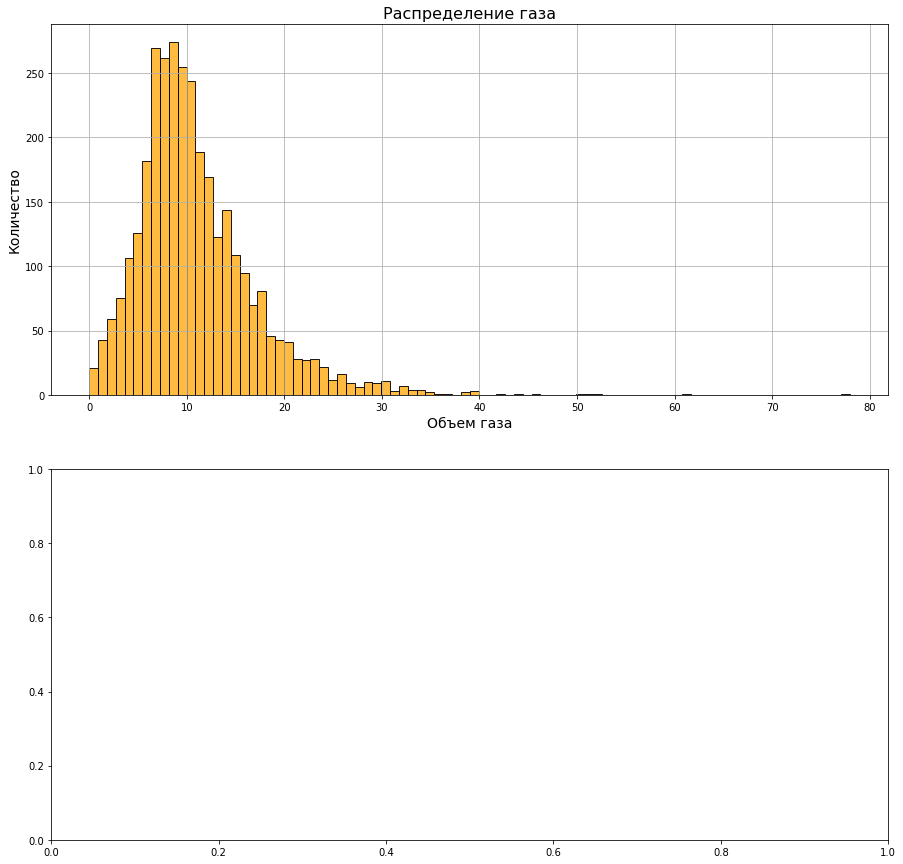

In [63]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_gas['газ'], color='orange')
plt.title('Распределение газа', fontsize=16)
plt.xlabel('Объем газа', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(data=data_gas['газ'], orient='h', palette='viridis')
plt.title('Диаграммы размаха количества газа для продувки сплава', fontsize=16)
plt.grid()

plt.tight_layout() 
plt.show()

**Вывод:**

* Название столбца было откорректированно.
* Значения добавления газа в сплав выглядят реалистичными, имеют биномодальное распределение. Максимальное значение равно 78, минимальное 0.008. Возможно, имея бы больше информации о диапазоне значений подачи газа в сплав, можно было бы откорректировать значения. Но в нашем случае оставим все как есть.

**Датасет data_temp:**

*Данные с результатами измерения температуры*

* Обработаем названия столбцов в соответствии с PEP8.
* Приведем столбцеч со временем замера к типу datetime.
* Обработаем аномалии - оставим температуры выше 1400.
* Также добавим столбцы с первым и последнем замером, чтобы обратотать данные с температурой. Для этого проведем группировку по партии и среди значений в каждой партии с помощью агрегатной функции выберем первое и последнее значение времени, создав соответствующие столбцы. Затем соединим новый датафрем со старым по началу замера и концу замера соответствующими значениями температуры.
* Рассмотрим пропцщенные значения в целевом датасете.


In [ ]:
data_temp.head()

In [64]:
data_temp = data_temp.rename(columns={
    'Время замера': 'время_замера',
    'Температура': 'температура'
})

data_temp.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [65]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [66]:
data_temp.describe()

,key,температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


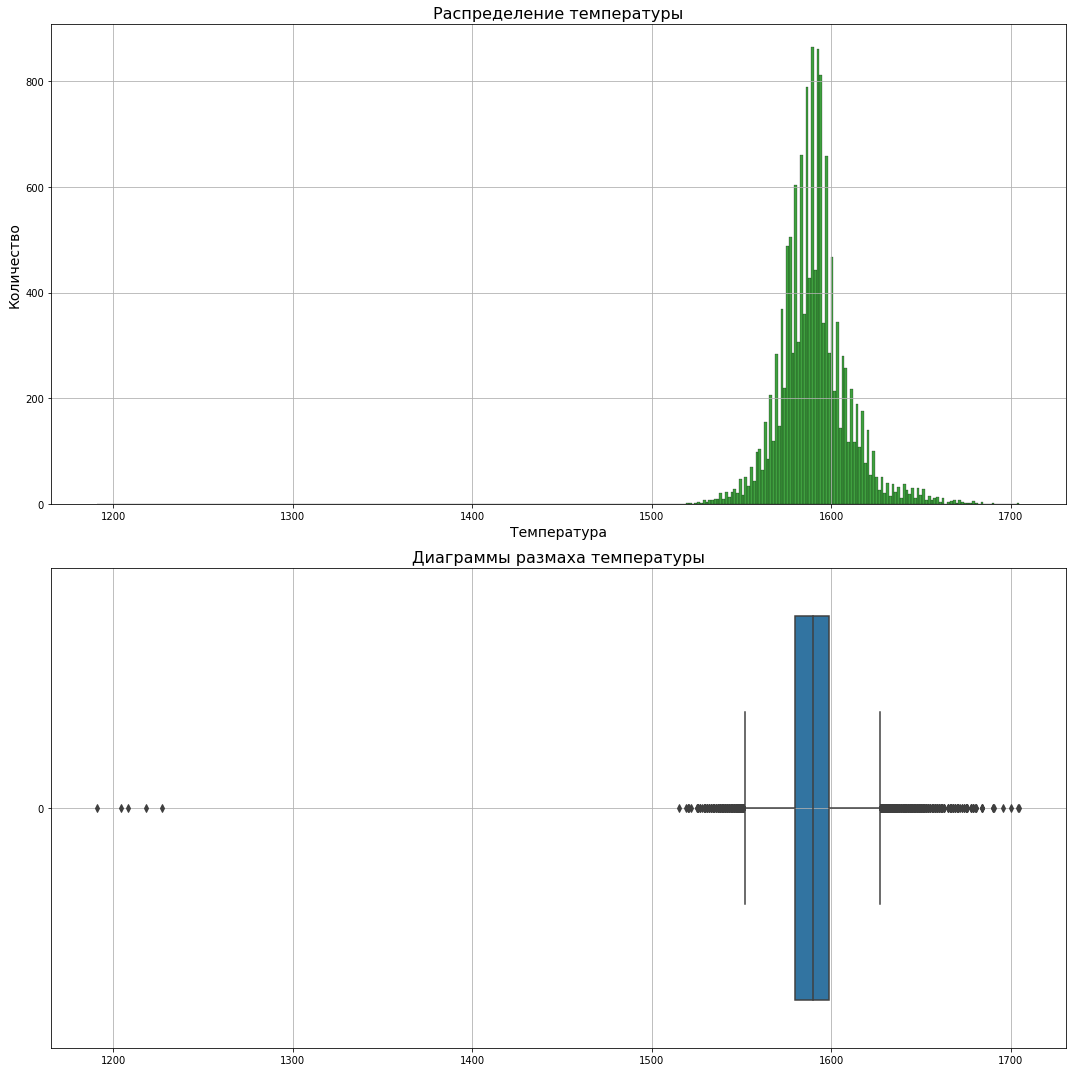

In [67]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_temp['температура'], color='g')
plt.title('Распределение температуры', fontsize=16)
plt.xlabel('Температура', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(data=data_temp['температура'], orient='h')
plt.title('Диаграммы размаха температуры', fontsize=16)
plt.grid()

plt.tight_layout() 
plt.show()

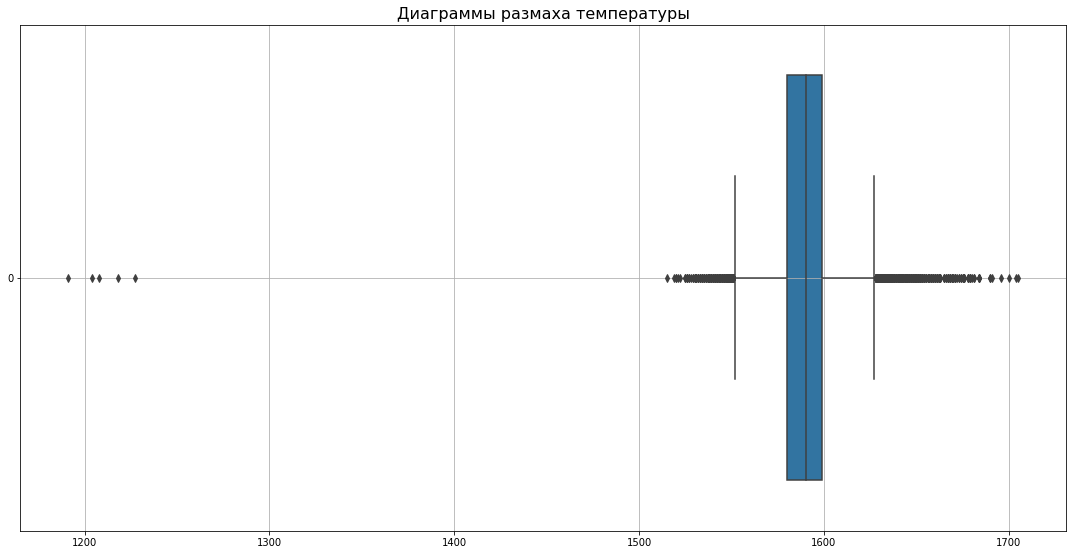

In [68]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 2)
sns.boxplot(data=data_temp['температура'], orient='h')
plt.title('Диаграммы размаха температуры', fontsize=16)
plt.grid()

plt.tight_layout() 
plt.show()

In [69]:
data_temp_group = data_temp.groupby('key')['время_замера'].agg(['first', 'last']).reset_index().rename(columns={
    'first': 'первый_замер',
    'last': 'последний_замер'
})
data_temp_group

,key,первый_замер,последний_замер
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39
...,...,...,...
3211,3237,2019-09-06 11:31:15,2019-09-06 11:55:45
3212,3238,2019-09-06 12:16:15,2019-09-06 12:34:37
3213,3239,2019-09-06 14:16:50,2019-09-06 15:09:55
3214,3240,2019-09-06 15:25:21,2019-09-06 16:35:26


In [70]:
data_temp_group = data_temp_group.merge(data_temp, 
                                        left_on=['key', 'первый_замер'],
                                        right_on=['key', 'время_замера']
                                       ).rename(columns={'температура': 'начальная_температура'})

data_temp_group = data_temp_group.merge(data_temp, 
                                        left_on=['key', 'последний_замер'],
                                        right_on=['key', 'время_замера']
                                       ).rename(columns={'температура': 'конечная_температура'})

data_temp_group#.head()

,key,первый_замер,последний_замер,время_замера_x,начальная_температура,время_замера_y,конечная_температура
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,2019-09-06 11:55:45,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3212,3238,2019-09-06 12:16:15,2019-09-06 12:34:37,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3213,3239,2019-09-06 14:16:50,2019-09-06 15:09:55,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3214,3240,2019-09-06 15:25:21,2019-09-06 16:35:26,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [71]:
data_temp_group.drop(['время_замера_x', 'время_замера_y'], axis=1, inplace=True)
data_temp_group.set_index('key', inplace=True)

In [72]:
data_temp = data_temp_group
data_temp

,первый_замер,последний_замер,начальная_температура,конечная_температура
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,NaN
3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,NaN
3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,NaN


In [73]:
data_temp = data_temp.drop(data_temp[data_temp['начальная_температура'] < 1400].index)
data_temp.shape

(3211, 4)

In [74]:
data_temp

,первый_замер,последний_замер,начальная_температура,конечная_температура
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,NaN
3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,NaN
3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,NaN


In [75]:
data_temp['конечная_температура'].isna().agg(['sum', 'mean'])

sum     738.000000
mean      0.229835
Name: конечная_температура, dtype: float64

In [76]:
data_temp.dropna(inplace=True)
data_temp.shape[0]

2473

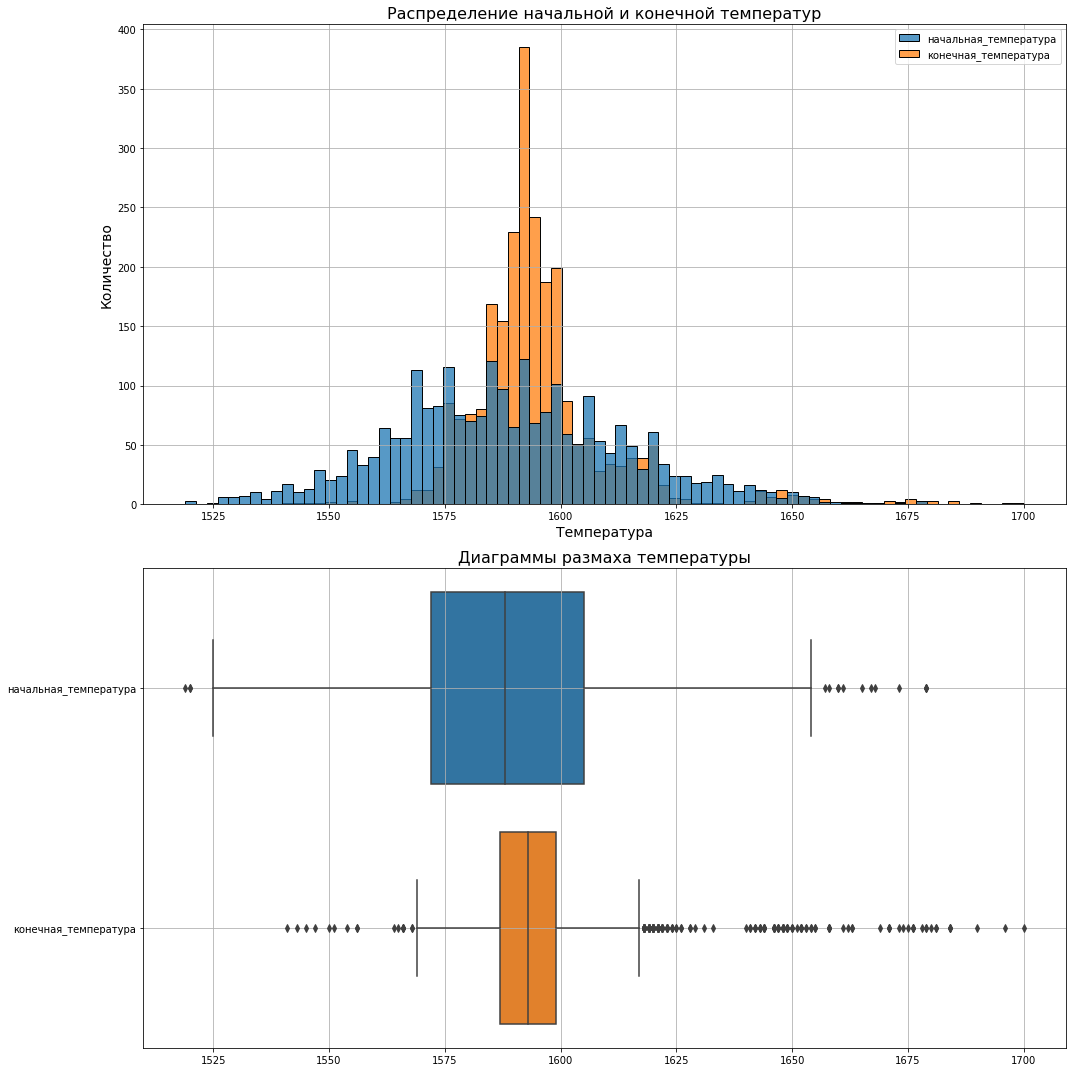

In [77]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_temp[['начальная_температура', 'конечная_температура']], color='g')
plt.title('Распределение начальной и конечной температур', fontsize=16)
plt.xlabel('Температура', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(data=data_temp[['начальная_температура', 'конечная_температура']], orient='h')
plt.title('Диаграммы размаха температуры', fontsize=16)
plt.grid()

plt.tight_layout() 
plt.show()

In [78]:
print('Пропущенные значения в датафрейме:')
data_temp.isna().agg(['sum', 'mean'])

Пропущенные значения в датафрейме:


,первый_замер,последний_замер,начальная_температура,конечная_температура
sum,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0


In [79]:
print(f'Количество строк в датафрейме = {data_temp.shape[0]}')

Количество строк в датафрейме = 2473


**Вывод:**

* Название столбцов были откорректированны.
* Значения в столбце "время замера" привели к типу даты.
* У значений температуры были выявлены выбросы (значения менее 1400) - их удалила. Максимальное значение равно 1705 - выглядит реальным.
* Обработали столбец со временем - оставили только температуры, относящиеся к первому и последнему замеру, а также их даты. Затем к каждому времени были приведены соответствующие температуры, появились следующие столбцы с данными: время начала и конца нагрева, а также температура в момент начала нагрева и в конце нагрева.
* Устранили пропущенные значения в датасете. Скорее всего, замена данных значений может негативно сказаться на будующих рассчетах, поэтому удалим их.
* Удалив пустые значения в целевом признаке, в результате мы получили датафрейм, состоящий из 2473 строк


**Датасет data_wire:**

*Данные о проволочных материалах, объем*

* Обработаем названия столбцов в соответствии с PEP8.
* Заменим NaN на нули для дальнейшей обработки данных
* Найдем суммарное значение проволочных материалов, сгруппированные по партиям.


In [80]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
rename_dict = {f'Wire {i}': f'wire_{i}' for i in range(1, 16)}

data_wire = data_wire.rename(columns=rename_dict)

data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


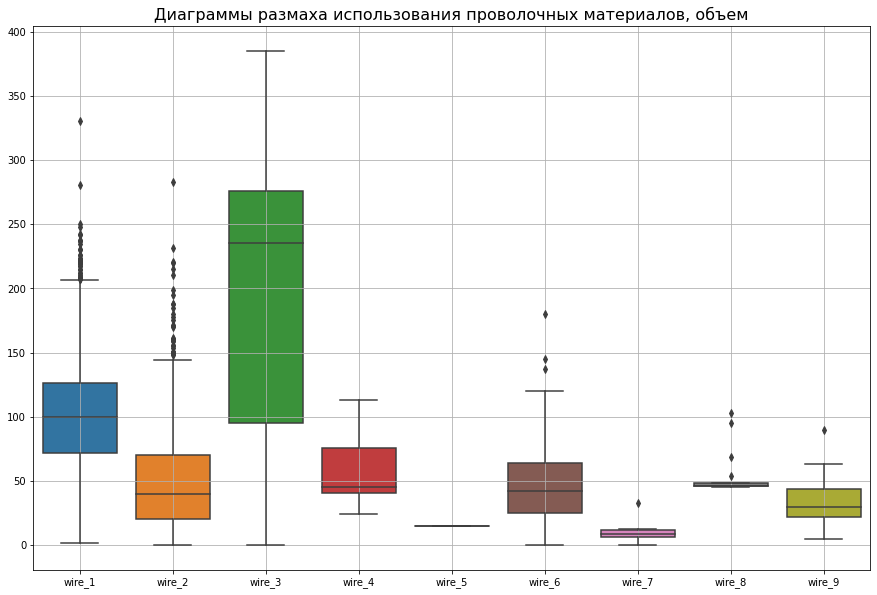

In [83]:
plt.figure(figsize=(15, 10))

sns.boxplot(data=data_wire.drop(columns=['key']))
plt.title('Диаграммы размаха использования проволочных материалов, объем', fontsize=16)
plt.grid()

plt.show()

In [84]:
data_wire = data_wire.fillna(0)

In [85]:
data_wire['проволочный_материал_сумма'] = data_wire.sum(axis=1)

In [86]:
data_wire.drop('wire_5', axis=1, inplace=True)

In [87]:
data_wire.set_index('key', inplace=True)

In [88]:
data_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,проволочный_материал_сумма
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,61.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,98.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,94.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,93.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,103.352796


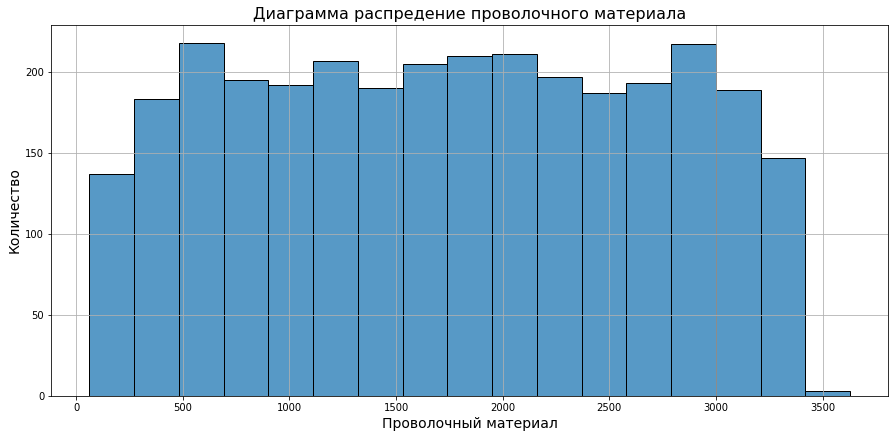

In [89]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.histplot(data=data_wire['проволочный_материал_сумма'])
plt.title('Диаграмма распредение проволочного материала', fontsize=16)
plt.xlabel('Проволочный материал', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()

plt.show()

**Вывод:**

* Проволочный материал 5 был добавлен всего лишь в одну партию - удалим его.
* Заменили все NaN на нули, чтобы просуммировать значения по партиям.
* Нашли суммарное количество добавленного материала по партиям
* Медианное значение проволочных материалов находится в диапазоне от 15 до 189.


**Датасет data_wire_time:**

*Данные о проволочных материалах, время*

* Обработаем названия столбцов в соответствии с PEP8.
* Учитывая, что мы удалили единственное значение 5 сыпучего материала, стоит удалить данный столбец в нынешнем датафрейме.
* Преобразуем данные в формат даты.
* Аналогично первому датасету, создадим время (длительность) добавления проволочных материалов, как разница начала и конца добавления материала. Для этого будем ориентироваться на минимальное и максимальное значение времени.

In [90]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
rename_dict = {f'Wire {i}': f'wire_{i}' for i in range(1, 16)}

data_wire_time = data_wire_time.rename(columns=rename_dict)

data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
for col in data_wire_time.columns:
    if col.startswith('wire_'):
        data_wire_time[col] = pd.to_datetime(data_wire_time[col], errors='coerce')

In [93]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [94]:
datetime_columns = data_wire_time.select_dtypes(include=['datetime64[ns]'])

data_wire_time['начало_добавления_проводочного_материала'] = datetime_columns.min(axis=1)
data_wire_time['конец_добавления_проводочного_материала'] = datetime_columns.max(axis=1)

data_wire_time['время_добавления_проводочного_материала'] = (
    data_wire_time['конец_добавления_проводочного_материала'] - 
    data_wire_time['начало_добавления_проводочного_материала']
).dt.total_seconds()

In [95]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,начало_добавления_проводочного_материала,конец_добавления_проводочного_материала,время_добавления_проводочного_материала
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0


In [96]:
data_wire_time.drop('wire_5', axis=1, inplace=True)

In [97]:
data_wire_time = data_wire_time[['key', 'время_добавления_проводочного_материала']]

In [98]:
data_wire_time.set_index('key', inplace=True)

In [99]:
data_wire_time.head()

,время_добавления_проводочного_материала
key,
1,0.0
2,0.0
3,0.0
4,0.0
5,310.0


KeyError: 0

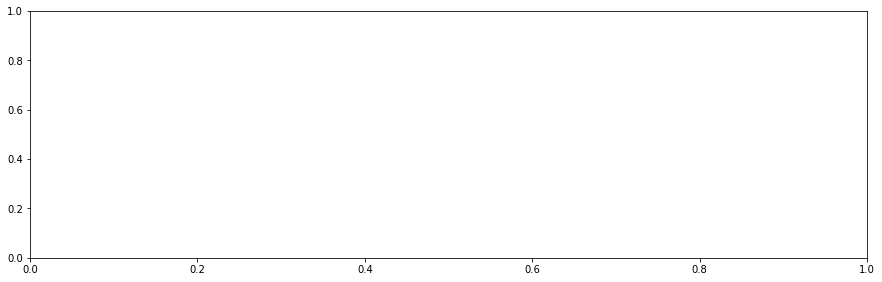

In [100]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 2)
sns.boxplot(data=data_wire_time['время_добавления_проводочного_материала'], orient='h')
plt.title('Диаграммы размаха времени добавления проволочных материалов', fontsize=16)
plt.grid()

plt.show()

In [ ]:
data_wire_time.describe()

**Вывод:**

* Исправили названия столбцов в соответствии с PEP8.
* Убрали информацию о 5 проволочном материале.
* Преобразовали данные в формат datetime, используя метод errors='coerce', чтобы, если в данных встретится значение, которое не может быть преобразовано в дату или время, то вместо вызова ошибки это значение будет заменено на NaT (аналог NaN).
* Добавили столбец "время_добавления_проволочного_материала" - длительность добавления проволочного материала, при этом удалили оставшиеся столбцы.
* Максимальное время добавления проволочного материала составляет 5937 секунд, минимальное равно 0 - оставим эти данные неизменными.

## Объединение данных и исследовательский анализ

Объединим предобработанные данные в один датафрейм по общему ключу key. В результирующую таблицу попадут только те строки, где значения ключей совпадают во всех объединяемых таблицах. Полученный датафрейм будем использовать для обучения моделей. В итоговый датафрейм *data* войдет следующая информация:

* какие значения температур были в начале и в конце замера;
* количество итераций в одной партии;
* время, потраченное на нагрев дугой;
* затраченная мощность;
* перечень всех сыпучих материалов;
* суммарное значение добавленных сыпучих материалов;
* время добавления сыпучих материалов;
* количество добавленного газа;
* перечень всех добавленных проволочных материалов;
* суммарное значение добавленных проволочных материалов;
* время, затраченное на добавление проволочных материалов.

Также рассмотрим корреляцию между признаками в полученном датафрейме.

In [101]:
data = data_temp.join([data_arc, data_bulk, data_bulk_time, data_gas, data_wire, data_wire_time], how='inner')
data.drop(['первый_замер', 'последний_замер'], axis=1, inplace=True)

In [102]:
data.head()

,начальная_температура,конечная_температура,количество_итераций,время_нагрева_дугой,мощность,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,проволочный_материал_сумма,время_добавления_проводочного_материала
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,1098.0,3.718736,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,61.059998,0.0
2,1581.0,1602.0,4,811.0,2.588349,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,98.052315,0.0
3,1596.0,1599.0,5,655.0,5.019223,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,94.160157,0.0
4,1601.0,1625.0,4,741.0,3.400038,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,93.063515,0.0
5,1576.0,1602.0,4,869.0,2.816980,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,103.352796,310.0


In [103]:
data[data['конечная_температура'] == 0]

,начальная_температура,конечная_температура,количество_итераций,время_нагрева_дугой,мощность,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,проволочный_материал_сумма,время_добавления_проводочного_материала
key,,,,,,,,,,,,,,,,,,,,,


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   начальная_температура                    2324 non-null   float64
 1   конечная_температура                     2324 non-null   float64
 2   количество_итераций                      2324 non-null   int64  
 3   время_нагрева_дугой                      2324 non-null   float64
 4   мощность                                 2324 non-null   float64
 5   bulk_1                                   2324 non-null   float64
 6   bulk_2                                   2324 non-null   float64
 7   bulk_3                                   2324 non-null   float64
 8   bulk_4                                   2324 non-null   float64
 9   bulk_5                                   2324 non-null   float64
 10  bulk_6                                   2324 no

In [254]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
начальная_температура,2324.0,1587.351549,23.619106,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
конечная_температура,2324.0,1593.356282,11.202150,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
количество_итераций,2324.0,4.692771,1.597005,1.000000,4.000000,5.000000,6.000000,16.000000
время_нагрева_дугой,2324.0,807.239243,338.734041,57.000000,581.000000,778.000000,993.000000,4189.000000
мощность,2324.0,3.882810,1.510275,0.331897,2.846893,3.768661,4.768665,15.288271
bulk_1,2324.0,3.355422,11.839550,0.000000,0.000000,0.000000,0.000000,94.000000
bulk_2,2324.0,1.425559,19.102530,0.000000,0.000000,0.000000,0.000000,325.000000
bulk_3,2324.0,47.273666,75.236198,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2324.0,37.322719,58.681436,0.000000,0.000000,0.000000,77.250000,281.000000
bulk_5,2324.0,2.645869,22.426054,0.000000,0.000000,0.000000,0.000000,603.000000


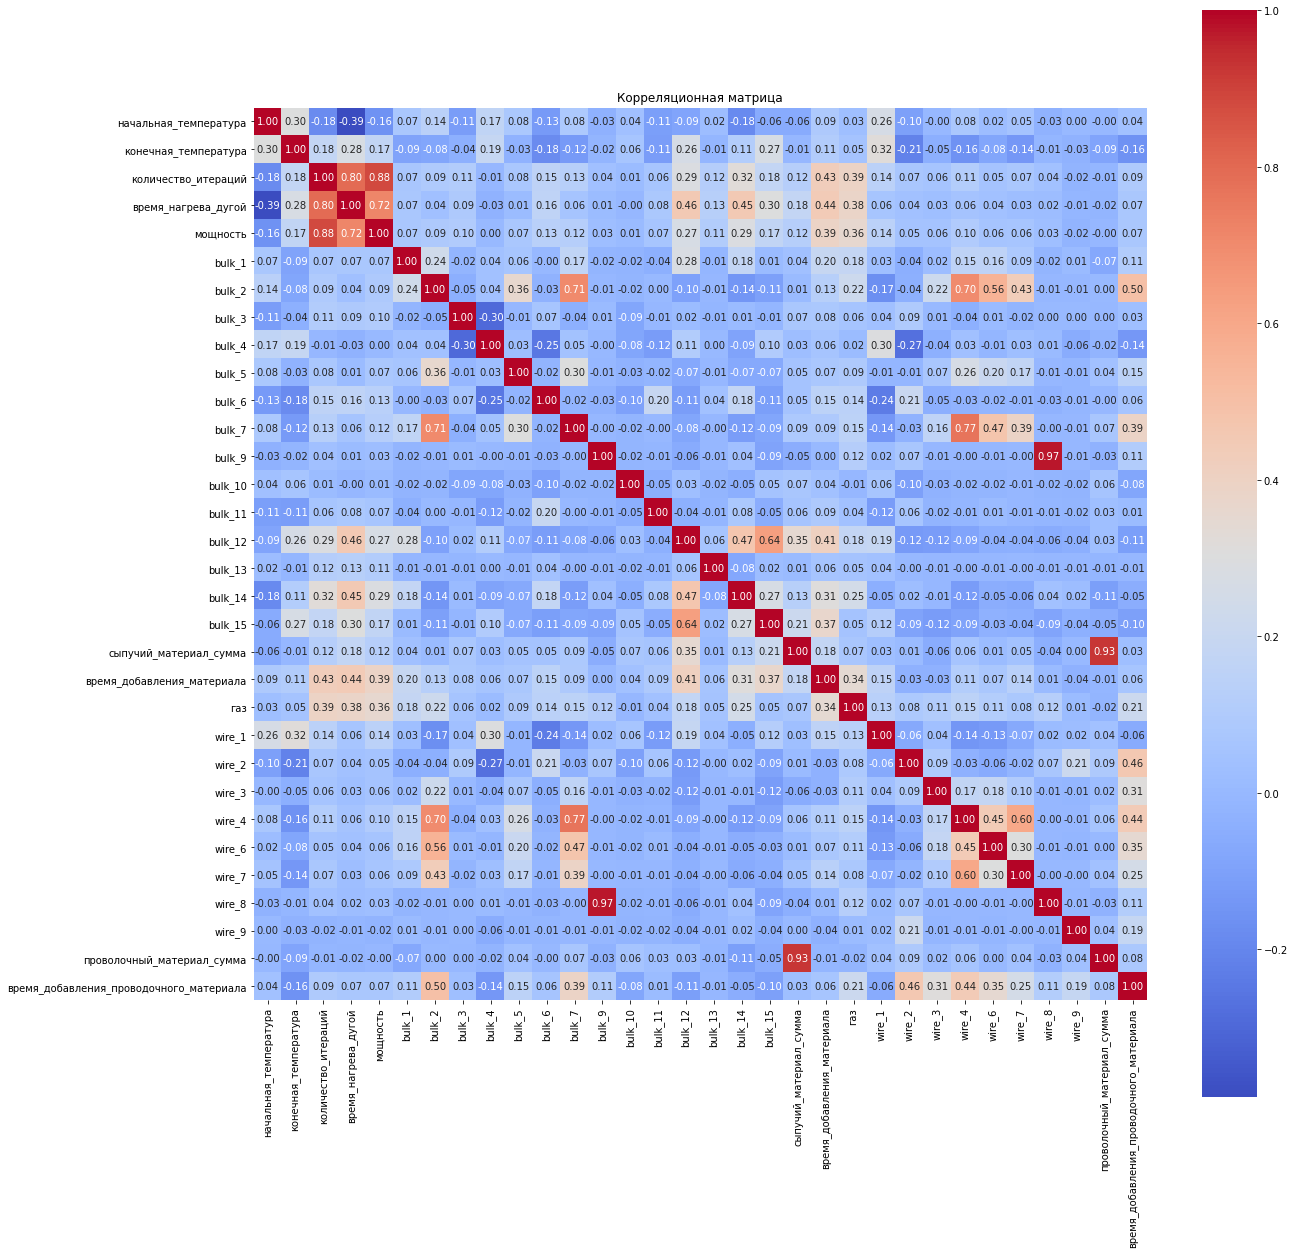

In [105]:
correlation_matrix = data.corr()

plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

In [106]:
data.corr().unstack()[(data.corr().unstack() < 1) & (abs(data.corr().unstack()) > 0.7)]

количество_итераций         время_нагрева_дугой           0.796315
                            мощность                      0.881988
время_нагрева_дугой         количество_итераций           0.796315
                            мощность                      0.716131
мощность                    количество_итераций           0.881988
                            время_нагрева_дугой           0.716131
bulk_2                      bulk_7                        0.706620
bulk_7                      bulk_2                        0.706620
                            wire_4                        0.770194
bulk_9                      wire_8                        0.974968
сыпучий_материал_сумма      проволочный_материал_сумма    0.925521
wire_4                      bulk_7                        0.770194
wire_8                      bulk_9                        0.974968
проволочный_материал_сумма  сыпучий_материал_сумма        0.925521
dtype: float64

In [107]:
data.corr().unstack()[(data.corr().unstack() < -0.7) & (abs(data.corr().unstack()) > -1)]

Series([], dtype: float64)

In [108]:
corr_target=pd.Series()
for col in data.columns:
    corr_target[col] = data['конечная_температура'].corr(data[col])
corr_target= corr_target.sort_values(ascending=False)[1:]

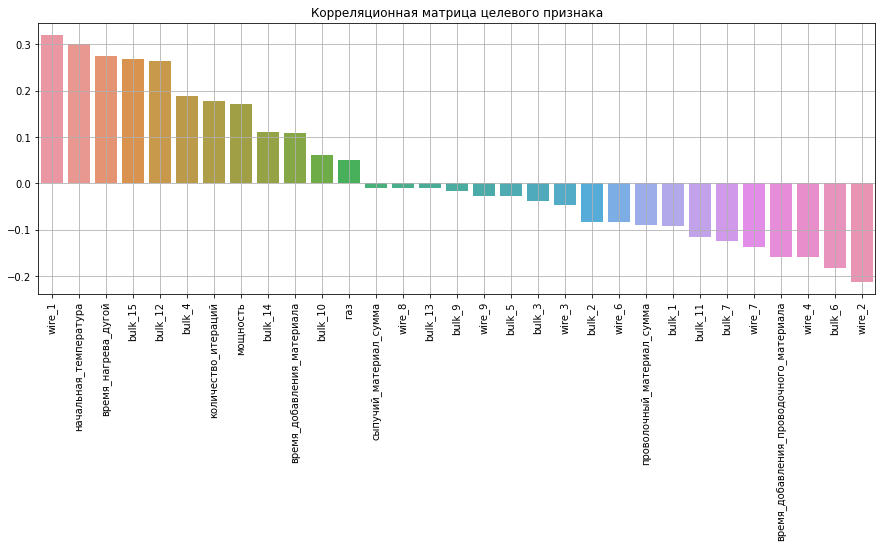

In [109]:
plt.figure(figsize=(15, 5))

sns.barplot(x=corr_target.index, y=corr_target.values)
plt.grid()
plt.xticks(rotation=90)
plt.title('Корреляционная матрица целевого признака')
plt.show()

**Вывод:**

В данном разделе был проведен корреляционный анализ данных. Наибольшей зависимостью обладают следующие признаки:

* Очень высокая корреляция (0.96) между сыпучим материалом и проволочным материалом показывает, что эти два процесса, вероятно, взаимозависимы и изменение одного компонента может оказывать значительное влияние на другой.
* Высокая корреляция между bulk_9 и wire_8 (0.98). Это может означать, что при использовании сыпучего материала 9, также должен добавляться проволочный материал 8.
* Существует положительная корреляция между bulk_2 и bulk_7 (0.78) - скорее всего, два данных материала чаще других используются в одном процессе.
* Мощность имеет очень сильную положительную корреляцию с количеством итераций (0.88). Высокий уровень мощности может быть необходим для выполнения большего количества итераций в партии.
* Также имеет высокую положительную корреляцию с количеством итераций (0.78). Это совпадает с предыдущим выводом о том, что время нагрева напрямую связано с количеством итераций.
* С сильной положительной корреляцией с временем нагрева дугой (0.78) и мощностью (0.88). Это указывает на то, что увеличение количества итераций связано с увеличением времени нагрева и мощности, что может свидетельствовать о том, что при большем количестве итераций время и мощность также увеличиваются.
* Сильная корреляция с таргетом не наблюдается. Максимальная корреляция есть с проволочным материалом 1 (чуть больше 0.3), начальной температурой (0.3), временем нагрева дугой (около 0.3) и другими признаками.

Значительная отрицательная корреляция между данными не выявлена.

## Подготовка данных

Выделим таргет и разделим полученный датасет на обучающую и тренировочную выборки

In [110]:
X = data.drop('конечная_температура', axis=1)
y = data['конечная_температура']

In [111]:
X.shape

(2324, 31)

In [112]:
y.shape

(2324,)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

## Обучение моделей машинного обучения 

### Линейные модели

Для начала, используя *StandardScaler* стандартизируем данные, преобразуя их так, чтобы среднее значение каждого было 0, а стандартное отклонение 1. Линейные модели лучше работают с отмасштабированными данными.

In [114]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_train_st = pd.DataFrame(X_train_st, columns=X_train.columns)

X_train_st

,начальная_температура,количество_итераций,время_нагрева_дугой,мощность,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,проволочный_материал_сумма,время_добавления_проводочного_материала
0,-0.853650,-0.435747,-0.156532,0.046877,-0.281892,-0.071906,-0.099715,-0.640921,-0.115915,-0.411799,...,0.077419,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,1.304300,-0.566152
1,2.433529,-1.069725,-0.303991,-1.143487,-0.281892,-0.071906,-0.627434,0.437834,-0.115915,-0.411799,...,0.422452,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,1.590143,-0.566152
2,-0.432217,-0.435747,-0.687384,-0.833775,-0.281892,-0.071906,-0.627434,-0.640921,-0.115915,1.476923,...,-0.976019,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,-0.412476,-0.566152
3,0.157790,0.832210,1.176498,1.304369,-0.281892,-0.071906,0.375231,-0.640921,-0.115915,-0.411799,...,0.472250,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,-0.535592,-0.566152
4,-0.980080,1.466189,1.863658,0.642772,-0.281892,-0.071906,5.243435,-0.640921,-0.115915,3.090921,...,-0.645120,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,0.875086,-0.566152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,-0.895793,0.198232,-0.666740,-0.454104,-0.281892,-0.071906,0.177337,-0.640921,-0.115915,-0.411799,...,0.165635,0.081932,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,0.579461,0.378934
1739,0.747796,1.466189,2.314883,2.092186,-0.281892,-0.071906,-0.627434,1.715742,-0.115915,-0.411799,...,1.729156,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,-0.952030,-0.566152
1740,0.494936,0.832210,0.504085,1.062842,-0.281892,-0.071906,-0.218452,-0.640921,-0.115915,-0.411799,...,-0.644396,-0.524095,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,-0.239910,-0.566152
1741,-0.685077,0.198232,0.052860,0.506397,-0.281892,-0.071906,-0.627434,-0.640921,-0.115915,-0.411799,...,-0.762837,0.081932,-0.09295,-0.06605,-0.110228,-0.024611,-0.072894,-0.094366,1.455712,0.376218


In [115]:
lr = LinearRegression()
mae_lr = abs(cross_val_score(lr, 
                             X=X_train_st, 
                             y=y_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error')).mean()
lr_mae = round(mae_lr, 2)
print(f"МАЕ модели линейной регрессии {lr_mae} градус")

МАЕ модели линейной регрессии 6.2 градус


Средняя абсолютная ошибка (МАЕ) у модели линейной регрессии при кросс валидации равна 6.21 градус - это значение лучше МАЕ, допустимого по условию.

In [116]:
lr_full = LinearRegression()
lr_full.fit(X=X_train_st, 
            y=y_train)

LinearRegression()

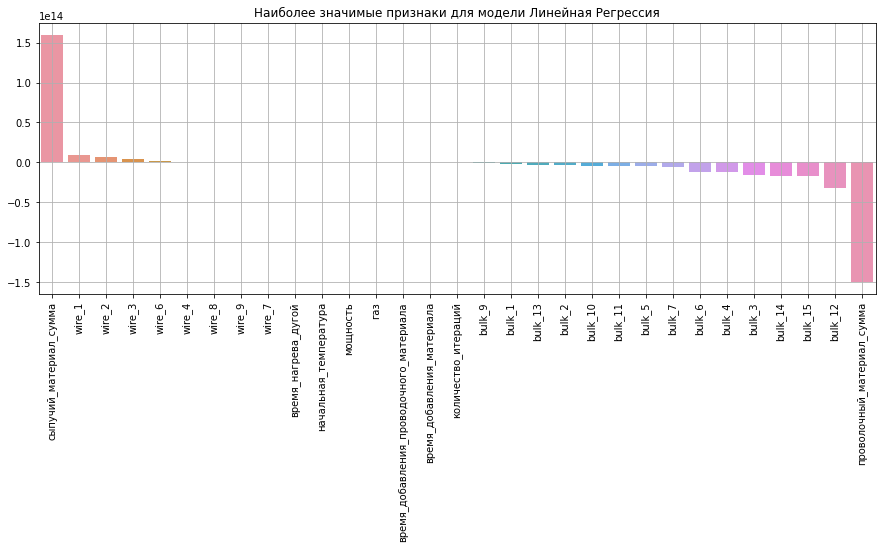

In [117]:
features_importances_plot(features_importances=lr_full.coef_, 
                          features_names=X_train_st.columns, 
                          model_name='Линейная Регрессия')

Мультиколлинеарность негативно повлияла на производительность модели линейной регрессии. Некоторые коэффициенты оказались слишком большими, что может вызвать проблемы с численной стабильностью и затрудняет интерпретацию значимости признаков.

Чтобы устранить эту проблему, рассмотрим использование регрессии с L1-регуляризацией (Lasso), которая способна уменьшить влияние мультиколлинеарности, и оценим её качество с помощью кросс-валидации.

Для настройки модели создадим функцию, которая будет выполнять случайный поиск по сетке гиперпараметров.

In [118]:
def random_search(model, hyperparams, n_iter=25, X_train=X_train, y_train=y_train):
    model_srch= RandomizedSearchCV(estimator=model, 
                                  param_distributions=hyperparams,
                                  n_iter=n_iter,
                                  cv=5, 
                                  scoring='neg_mean_absolute_error',
                                  random_state=RANDOM_STATE)
    model_srch.fit(X_train, y_train)

    print(f'Лучшие гиперпараметры модели: {model_srch.best_params_}')
    print(f'MAE лучшей модели на кросс-валидации: {round(abs(model_srch.best_score_), 2)}')
    return model_srch

In [120]:
lasso_hyperparams = {'alpha' : np.linspace(0, 1, 100)}

In [121]:
lasso = random_search(Lasso(), lasso_hyperparams, n_iter=50, X_train=X_train_st, y_train=y_train)

Лучшие гиперпараметры модели: {'alpha': 0.0}
MAE лучшей модели на кросс-валидации: 6.2


In [122]:
lasso_full = Lasso(**lasso.best_params_)
lasso_full.fit(X_train_st, y_train)

Lasso(alpha=0.0)

Производительность модели немного повысилась в сравнении с линейной регрессией, которая не использовала регуляризацию.

Теперь проанализируем коэффициенты признаков в модели LASSO-регрессии, которая показала наилучший результат на кросс-валидации.

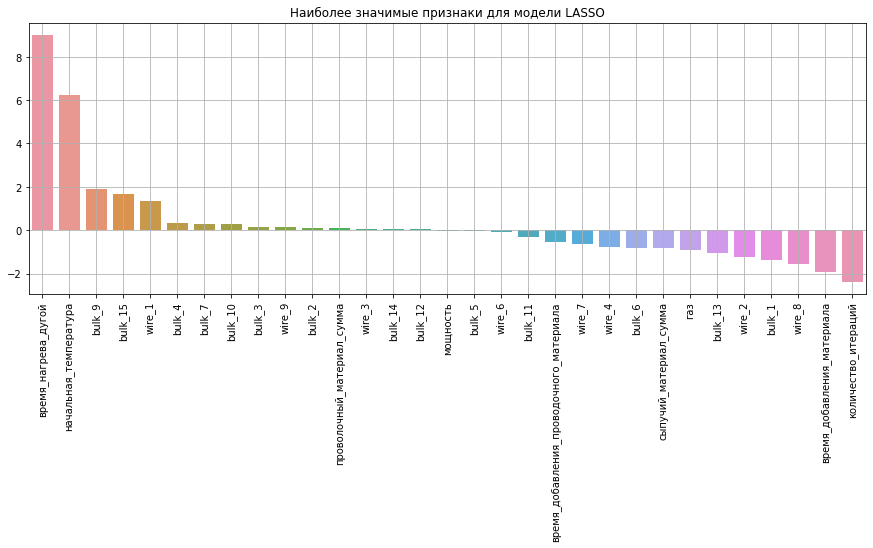

In [123]:
features_importances_plot(features_importances=lasso_full.coef_, 
                          features_names=X_train_st.columns, 
                          model_name='LASSO')

В модели с L1-регуляризацией наибольший вклад вносит время нагрева дугой и начальная температура. Также значимы сыпучие материалы.

При этом коэффициенты для некоторых сыпучих и проволочных материалов, а также для расчетных признаков, связанных с их суммарными значениями, были обнулены, что указывает на их меньшую важность для модели.

In [124]:
ridge_hyperparams = {'alpha' : np.linspace(0, 100, 1000)}

In [125]:
ridge = random_search(Ridge(), 
                      ridge_hyperparams, 
                      n_iter=50, 
                      X_train=X_train_st, 
                      y_train=y_train)

Лучшие гиперпараметры модели: {'alpha': 7.007007007007007}
MAE лучшей модели на кросс-валидации: 6.2


Средняя абсолютная ошибка (МАЕ) у моделина кросс-валидации LASSO равна 6.16 - она показала лучшее качество.

### Случайный лес

Рассмотрим, как модель случайного леса показывает себя на кросс-валидации без предварительной настройки гиперпараметров. Это позволит оценить её базовую производительность и понять, насколько она эффективна "из коробки".

In [126]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE, 
                            criterion='absolute_error', 
                            n_jobs=-1)

mae_rfr = abs(cross_val_score(rfr, 
                              X=X_train, 
                              y=y_train, 
                              cv=5, 
                              scoring='neg_mean_absolute_error')).mean()
mae_rfr = round(mae_rfr, 2)

print(f"Средняя абсолютная ошибка (МАЕ) у модели случайный лес {mae_rfr}.")

Средняя абсолютная ошибка (МАЕ) у модели случайный лес nan.


Качество модели по метрике средней абсолютной ошибки (MAE) составляет 6,32, что хуже, чем у линейных моделей.
Обычно производительность модели Случайного Леса улучшается за счет увеличения числа деревьев. Мы начнем с настройки нескольких гиперпараметров, которые влияют на создание подвыборок, а затем оценим, как увеличение количества деревьев скажется на качестве модели.

In [127]:
rfr_hyperparams = {
    'max_features': np.arange(0.4, 0.8, 0.2),
    'bootstrap': [False, True],
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfr = random_search(RandomForestRegressor(random_state=RANDOM_STATE, 
                                          criterion='absolute_error',
                                          n_jobs=-1), 
                    rfr_hyperparams, 
                    n_iter=15,
                    X_train=X_train, 
                    y_train=y_train)

KeyError: 'absolute_error'

Показатель МАЕ модели *Случайного леса* с добавлением гиперпараметров немного ухудшился и стал 6.34. Рассмотрим, как будет изменяться качество модели с увеличением деревьев

In [128]:
n_trees_influence = {}
for cnt in np.arange(25, 251, 25):
    
    best_params = rfr.best_params_.copy()
    if 'n_estimators' in best_params:
        del best_params['n_estimators']
    
    
    rfr_model = RandomForestRegressor(n_estimators=cnt, 
                                      criterion='absolute_error', 
                                      random_state=RANDOM_STATE, 
                                      **best_params)
    
    
    mae_rfr = abs(cross_val_score(rfr_model, 
                                  X=X_train, 
                                  y=y_train, 
                                  cv=3, 
                                  scoring='neg_mean_absolute_error')).mean()
    n_trees_influence[cnt] = round(mae_rfr, 2)


AttributeError: 'RandomForestRegressor' object has no attribute 'best_params_'

In [364]:
pd.Series(n_trees_influence)

25     6.40
50     6.32
75     6.31
100    6.29
125    6.28
150    6.27
175    6.28
200    6.28
225    6.28
250    6.29
dtype: float64

Лучшее количество деревьев *150*. При данном количестве МАЕ равно *6.27*.

In [370]:
best_params = rfr.best_params_.copy()

if 'n_estimators' in best_params:
    del best_params['n_estimators']

rfr_full = RandomForestRegressor(n_estimators=200, 
                                 criterion='absolute_error', 
                                 random_state=RANDOM_STATE, 
                                 **best_params)

In [372]:
rfr_full.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error',
                      max_features=0.6000000000000001, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200,
                      random_state=250722)

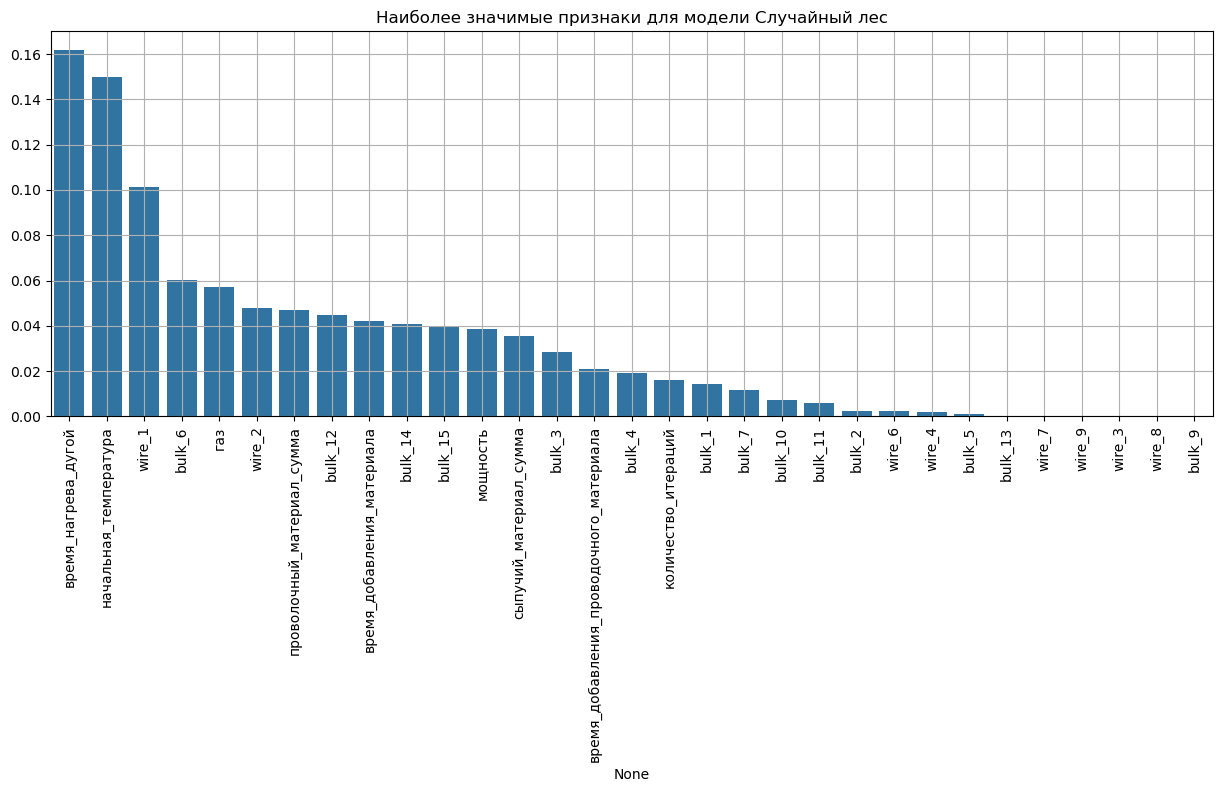

In [373]:
features_importances_plot(features_importances=rfr_full.feature_importances_, 
                          features_names=X_train_st.columns, 
                          model_name='Случайный лес')

Наиболее значимым признаком по модели Случайного Леса, как и у линейной модели LASSO является время нагрева дугой и начальная температура. 

В отличие от модели ЛАССО для Случайного Леса достаточно важными также являются такие признаки, как газ, добавление проволочных материалов и их время, а также другие сыпучие и проволочные материалы.

### Градиентный бустинг

Для начала рассмотрим модель "из коробки", без настроек гиперпараметров

In [129]:
lgb = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
mae_lgb = abs(cross_val_score(lgb, 
                              X=X_train, 
                              y=y_train, 
                              cv=5, 
                              scoring='neg_mean_absolute_error')).mean()
mae_lgb = round(mae_lgb, 2)

print(f"Средняя абсолютная ошибка (МАЕ) у модели градиентного бустинга {mae_lgb}.")

Средняя абсолютная ошибка (МАЕ) у модели градиентного бустинга 6.27.


Качество модели Градиентного Бустинга "из коробки" оказалась такой же, как у Случайного Леса, но хуже, чем у линейных моделей.

На первом этапе настроим ряд гиперпараметров за исключением числа итерации, на втором этапе запустим модель с подобранными гиперпараметрами на большом количестве деревьев с низкими темпами обучения и ранней остановкой

In [130]:
lgb_hyperparams = {'max_depth'        : range(1, 10, 1),
                   'subsample'        : np.arange(0.5, 1, 0.1),
                   'feature_fraction' : np.arange(0.5, 1, 0.1),
                   'reg_alpha'        : np.arange(0, 1, 0.05),
                   'reg_lambda'       : np.arange(0, 30, 5)}

In [131]:
lgb = random_search(LGBMRegressor(random_state=RANDOM_STATE, 
                                  metric='mae'), 
                    lgb_hyperparams, 
                    n_iter=50, 
                    X_train=X_train, 
                    y_train=y_train)

[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] feature_fraction is set=0.7999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999999999999999
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fea

МАЕ  на 100 итерациях градиентного бустинга достигла 6.11 градусов - на данном этапе это лучшее значение.

In [426]:
best_params = lgb.best_params_.copy()

# Удаляем конфликтующие параметры, которые уже переданы явно
for param in ['max_depth', 'num_leaves', 'min_child_samples']:
    if param in best_params:
        del best_params[param]

lgb_full = LGBMRegressor(
    n_estimators=2000, 
    learning_rate=0.01,
    random_state=RANDOM_STATE, 
    metric='mae', 
    early_stopping_rounds=50,
    max_depth=-1,          # Явно заданное значение
    num_leaves=31,         # Явно заданное значение
    min_child_samples=20,  # Явно заданное значение
    **best_params          # Остальные параметры из подбора
)

X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

lgb_full.fit(
    X_train_lgb, y_train_lgb,
    eval_set=(X_val_lgb, y_val_lgb),
    eval_metric='mae'
)

[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 22
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_

LGBMRegressor(early_stopping_rounds=50, feature_fraction=0.8999999999999999,
              learning_rate=0.01, metric='mae', n_estimators=2000,
              random_state=250722, reg_alpha=0.65, reg_lambda=10,
              subsample=0.7999999999999999)

Для темпа обучения 0,005 достаточно чуть больше 1000 деревьев, MAE на валидационной выборке составила 5,96 град.

In [416]:
mae_df = pd.DataFrame( index=['LASSO', 'Random Forest', 'Gradient Boosting'],
                       data = {'MAE_val':[6.16, 6.27, 5.96]})
mae_df

,MAE_val
LASSO,6.16
Random Forest,6.27
Gradient Boosting,5.96


## Выбор лучшей модели

Лучшее качество по метрике MAE получена для модели Градиентного бустинга, рассчитаем качество данной модели на тесте.

In [429]:
lgb_mae_test = round(mae(y_test, lgb_full.predict(X_test)), 2)
print('МАЕ для модели градиентного бустинга на ткстовой выборке равно:', lgb_mae_test)

[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
МАЕ для модели градиентного бустинга на ткстовой выборке равно: 6.41


Качество по метрике MAE модели градиентного бустинга на тестовой выборке составила 5,58 град. Таким образом получена модель, соответствующая требованиям Заказчика к качеству модели. Данная модель может быть рекомендована для использования при прогнозе конечной температуры стали.

## Общий вывод

В ходе работы были выполнены следующие этапы:

1. Загрузка и предобработка данных
   
* Были загружены данные о материалах, используемых на металлургическом комбинате, включая данные об электродах, сыпучих материалах, продувке газом, результатах измерения температуры и проволочных материалах.

* Проведена предобработка данных:

    * Удалены аномалии и выбросы (например, удалены материалы, добавленные в одну партию, и некорректные значения температуры).

    * Заполнены пропущенные значения (NaN заменены на нули).

    * Преобразованы данные в формат datetime для корректной работы с временными метками.
 
    * Созданы новые признаки, такие как время добавления материалов и длительность процессов.

* Проведен исследовательский анализ данных:

    * Выявлены корреляции между признаками (например, высокая корреляция между сыпучими и проволочными материалами, а также между мощностью и количеством итераций).
    * 
    * Удалены мультиколлинеарные признаки для улучшения качества моделей.

2. Объединение данных

* Все датасеты были объединены в единый по общему ключу key.

* Проведен анализ общего датафрейма:

    * Выявлены сильные корреляции между некоторыми признаками (например, между bulk_9 и wire_8, а также между мощностью и количеством итераций).

    * Отсутствует значимая корреляция между целевым признаком (температурой) и остальными признаками, что усложняет задачу прогнозирования.

3. Подготовка данных к обучению
   
* Данные были разделены на обучающую и тестовую выборки.

* Проведено масштабирование признаков для улучшения сходимости моделей.

4. Обучение моделей
   
* Были обучены и протестированы следующие модели:

    * Линейная регрессия: MAE = 6.21. Мультиколлинеарность негативно повлияла на производительность модели.

    * Линейная регрессия с L1-регуляризацией (Lasso): MAE = 6.20. L1-регуляризация помогла уменьшить влияние мультиколлинеарности.
 
    * Случайный лес без настройки гиперпараметров: MAE = 6.32.
 
    * Случайный лес с настройкой гиперпараметров: MAE = 6.34. Настройка гиперпараметров не привела к значительному улучшению.
 
    * Градиентный бустинг (LightGBM): Без настройки гиперпараметров: MAE = 6.27.
 
    * Градиентный бустинг с настройкой количества деревьев: MAE = 6.11 (на 100 итерациях).
 
    * Градиентный бустинг с настройкой темпа обучения (learning rate = 0.005) и количества деревьев (1000): MAE = 5.96 на валидационной выборке.

* Лучшая модель по метрике MAE — **градиентный бустинг (LightGBM)** с MAE = 6.41 на тестовой выборке.

5. Итоговые выводы
   
* Градиентный бустинг показал наилучшие результаты благодаря своей способности учитывать сложные нелинейные зависимости в данных.

* Настройка гиперпараметров (количество деревьев, темп обучения) позволила улучшить качество модели.

* Мультиколлинеарность и отсутствие сильной корреляции между целевым признаком и остальными признаками ограничили производительность линейных моделей.

* Для дальнейшего улучшения результатов можно:

    * Провести более тщательный подбор гиперпараметров для градиентного бустинга.

    * Исследовать дополнительные признаки или методы feature engineering.

    * Рассмотреть использование ансамблевых методов (например, стекинг или блендинг).

Таким образом, градиентный бустинг является наиболее подходящей моделью для прогнозирования температуры в данной задаче, демонстрируя наилучшее качество предсказаний.